In [1]:
import sys
sys.path.append('./src/')

import numpy as np
import pandas as pd

from src.benchmarks import *
from src.utils_data import prepare_data, seas_dict
from src.utils_evaluation import *
from src.utils_visualization import plot_grid_series, plot_distributions

from src.utils_ml import ml_pipeline


directory ./data/m4/Yearly.csv

 Fitting models
Naive
SeasonalNaive
Naive2
RandomWalkDrift
Croston
MovingAverage
SeasonalMovingAverage

 Evaluating models
RMSE
MAPE
SMAPE
MASE
RMSSE


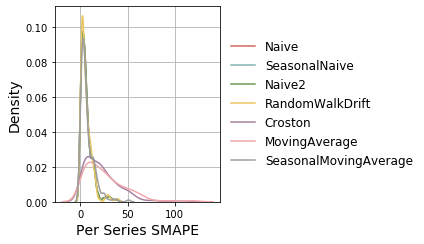

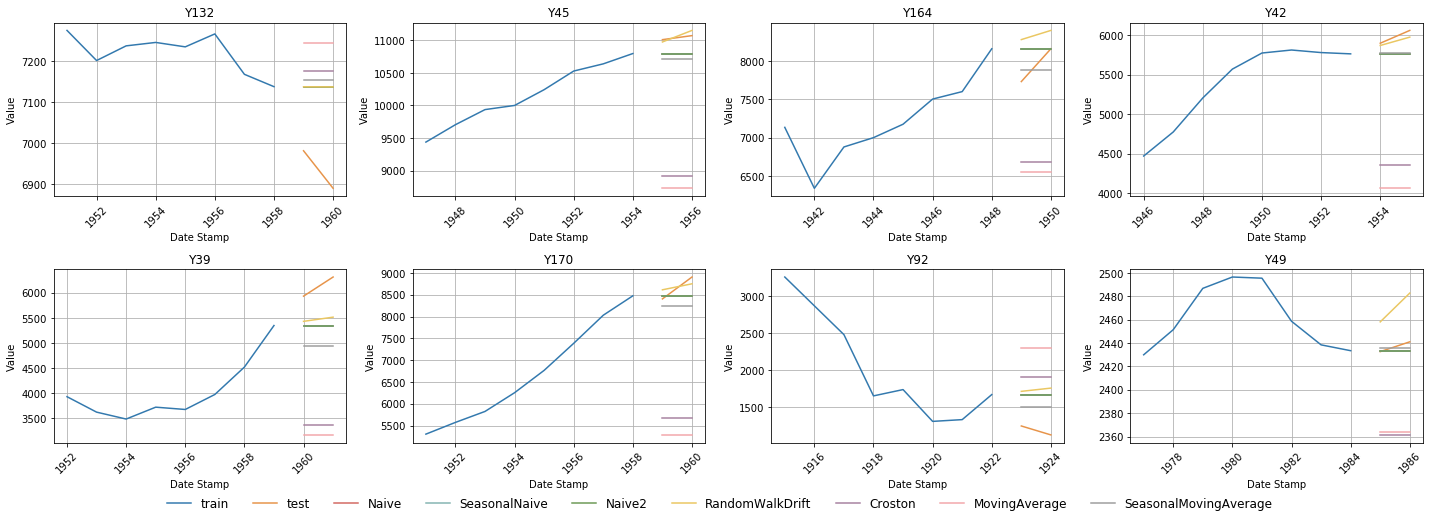

In [2]:
# directory = './data/m4/Hourly.csv'
# freq = 'Hourly'
# h = 24

# directory = './data/m4/Daily.csv'
# freq = 'Daily'
# h = 14

# directory = './data/m4/Weekly.csv'
# freq = 'Weekly'
# h = 4

# directory = './data/m4/Monthly.csv'
# freq = 'Monthly'
# h = 3

# directory = './data/m4/Quarterly.csv'
# freq = 'Quarterly'
# h = 1

directory = './data/m4/Yearly.csv'
freq = 'Yearly'
h = 2

# Parse time series arguments
seasonality = seas_dict[freq]['seasonality']

models = {'Naive':  Naive(h=h),
          'SeasonalNaive': SeasonalNaive(h=h, seasonality=seasonality),
          'Naive2': Naive2(h=h, seasonality=seasonality),
          'RandomWalkDrift': RandomWalkDrift(h=h),
          'Croston': Croston(kind='classic'),
          'MovingAverage': MovingAverage(h=h, n_obs=20),
          'SeasonalMovingAverage': SeasonalMovingAverage(h=h, n_seasons=2,
                                                         seasonality=seasonality)}

metrics = {'RMSE': rmse, 'MAPE': mape, 'SMAPE': smape, 
           'MASE': mase, 'RMSSE': rmsse}

y_df, models = ml_pipeline(directory, h, freq, models, metrics)